In [162]:
# load libraries
import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from pyproj import Geod
import numpy as np

In [174]:
# Load OceanParcels output
model_data = xr.open_zarr("output_model/Caranx/Ch2_caranx_1993_south_pld58_depth6to20_AprNov_night.zarr", consolidated=False)
#name output file
output_csv = "particle_closest_to_land_Caranx_1993_south.csv"

In [175]:
# load land with names but only to country level unfortunately 
countries = gpd.read_file("ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")
countries = countries.to_crs("EPSG:4326") # ensure lon/lat
countries_sindex = countries.sindex
countries.head

<bound method NDFrame.head of           featurecla  scalerank  LABELRANK                    SOVEREIGNT  \
0    Admin-0 country          0          2                     Indonesia   
1    Admin-0 country          0          3                      Malaysia   
2    Admin-0 country          0          2                         Chile   
3    Admin-0 country          0          3                       Bolivia   
4    Admin-0 country          0          2                          Peru   
..               ...        ...        ...                           ...   
253  Admin-0 country          0          4                         China   
254  Admin-0 country          6          5                     Australia   
255  Admin-0 country          6          8  Bajo Nuevo Bank (Petrel Is.)   
256  Admin-0 country          6          5               Serranilla Bank   
257  Admin-0 country          6          6              Scarborough Reef   

    SOV_A3  ADM0_DIF  LEVEL               TYPE TLC  \
0  

In [176]:
# Check the lat/lon - it is -180 to 180 so I have to change parcels output
print("Habitat CRS:", countries.crs)
print("Habitat bounds:", countries.total_bounds)
habitat.columns

Habitat CRS: EPSG:4326
Habitat bounds: [-180.          -90.          180.           83.63410065]


Index(['featurecla', 'scalerank', 'min_zoom', 'geometry'], dtype='str')

In [177]:
# fine scale names for naming closest land - this is actually too fine of scale
islands_df = pd.read_csv("geonames_islands.tsv", sep="\t")

islands = gpd.GeoDataFrame(
    islands_df,
    geometry=gpd.points_from_xy(islands_df.longitude, islands_df.latitude),
    crs="EPSG:4326"
)

islands_sindex = islands.sindex


In [179]:
# Parcels dataset
lon = model_data['lon'].values
lat = model_data['lat'].values
age = model_data['age'].values / (24*3600)  # convert age to days
release_site = model_data['releaseSite'].values
particle_ids = np.arange(lon.shape[0])

# Convert longitudes 0-360 -> -180 to 180
lon = np.where(lon > 180, lon - 360, lon)

In [180]:
# Distance threshold for settlement
settle_distance_km = 10

# Particle age filter
presettlement = 50
PLD = 80

# Release site mapping
country_codes = {
    1: "Big Island", 2: "Maui Nui", 3: "Oahu", 4: "Kauai", 5: "Niihau",
    6: "NWHI", 7: "Baker Island", 8: "Howland Island", 9: "Johnston",
    10: "Kingman", 11: "Kiritibati", 12: "Kiritimati", 13: "Marshall Islands",
    14: "Micronesia", 15: "Palmyra", 16: "Wake Island", 17: "China",
    18: "Guam", 19: "Indonesia", 20: "Japan", 21: "Northern Mariana Islands",
    22: "Palau", 23: "Philippines", 24: "South of Guam", 25: "Taiwan"
}

In [181]:
geod = Geod(ellps="WGS84")

In [182]:
def get_ne_name_from_countries(closest_lon, closest_lat):
    """
    Return the country name (ADMIN) from Natural Earth polygons.
    Works with MultiPolygons.
    """
    pt = Point(closest_lon, closest_lat)
    name_col = 'ADMIN'  # column in ne_10m_admin_0_countries.shp

    # First: check if point is inside a polygon
    possible = list(countries_sindex.intersection(pt.bounds))
    for idx in possible:
        geom = countries.geometry.iloc[idx]
        if geom.contains(pt):
            return countries[name_col].iloc[idx]

    # Fallback: find nearest polygon (works for multipolygons)
    min_dist = np.inf
    nearest_name = None
    for geom, name in zip(countries.geometry, countries[name_col]):
        if isinstance(geom, Polygon):
            polygons = [geom]
        elif isinstance(geom, MultiPolygon):
            polygons = geom.geoms
        else:
            continue
        for poly in polygons:
            nearest_pt = poly.exterior.interpolate(poly.exterior.project(pt))
            dist = pt.distance(nearest_pt)
            if dist < min_dist:
                min_dist = dist
                nearest_name = name

    return nearest_name


In [183]:
def get_nearest_geonames_island(lon, lat, islands_gdf):
    pt = Point(lon, lat)
    # Compute distances (geodesic)
    distances = []
    for isl_pt in islands_gdf.geometry:
        _, _, dist_m = geod.inv(lon, lat, isl_pt.x, isl_pt.y)
        distances.append(dist_m / 1000.0)  # km
    idx_min = np.argmin(distances)
    return islands_gdf.iloc[idx_min]["name"]

In [184]:
def closest_point_distance(lons, lats, land_gdf):
    """
    For a particle's trajectory, find the closest distance to land.
    Handles both Polygon and MultiPolygon geometries.
    Returns: index of closest time step, lon, lat, age, min distance in km
    """
    min_dist = np.inf
    closest_idx = None

    for i, (lon_pt, lat_pt) in enumerate(zip(lons, lats)):
        pt = Point(lon_pt, lat_pt)

        for geom in land_gdf.geometry:
            # If MultiPolygon, loop over individual polygons
            if isinstance(geom, Polygon):
                polys = [geom]
            elif isinstance(geom, MultiPolygon):
                polys = list(geom.geoms)
            else:
                continue  # skip other geometry types

            for poly in polys:
                nearest_pt = poly.exterior.interpolate(poly.exterior.project(pt))
                # geodesic distance
                _, _, dist_m = geod.inv(lon_pt, lat_pt, nearest_pt.x, nearest_pt.y)
                dist_km = dist_m / 1000
                if dist_km < min_dist:
                    min_dist = dist_km
                    closest_idx = i

    return closest_idx, min_dist


In [ ]:
# Test only first 5 particles
# num_test_particles = 5
# for p in range(lon.shape[0]):

# ---------------------------
# Iterate over particles
# ---------------------------
rows = []

for p in range(lon.shape[0]):
    age_mask = (age[p] >= presettlement) & (age[p] <= PLD)
    if not age_mask.any():
        continue
    lons_particle = lon[p, age_mask]
    lats_particle = lat[p, age_mask]
    ages_particle = age[p, age_mask]
    if len(lons_particle) == 0:
        continue
    idx, min_dist = closest_point_distance(lons_particle, lats_particle, countries)
    closest_lon = lons_particle[idx]
    closest_lat = lats_particle[idx]
    closest_age = ages_particle[idx]
    settled = min_dist <= settle_distance_km

    # Get names
    ne_name = get_ne_name_from_countries(closest_lon, closest_lat)
    geonames_name = get_nearest_geonames_island(closest_lon, closest_lat,islands)

    rows.append({
        "particle_id": particle_ids[p],
        "release_site": country_codes[int(release_site[p, 0])],
        "lon_closest": closest_lon,
        "lat_closest": closest_lat,
        "age_closest": closest_age,
        "min_distance_km": min_dist,
        "settled": settled,
        "ne_island_name": ne_name,
        "geonames_island_name": geonames_name
    })


In [ ]:
# Save output
df = pd.DataFrame(rows)
df.to_csv(output_csv, index=False)
print(f"Saved closest-to-land info for {len(df)} particles to {output_csv}")

In [161]:
df = pd.DataFrame(rows)
print(df)

   particle_id release_site  lon_closest  lat_closest  age_closest  \
0            0   Kiritibati   169.401154     7.189701         58.0   
1            1   Kiritibati   172.410599     9.823226         58.0   
2            2   Kiritibati   172.185272    10.160378         58.0   
3            3   Kiritibati   172.054596    10.074483         58.0   
4            4   Kiritibati   169.345169     7.201153         58.0   

   min_distance_km  settled    ne_island_name geonames_island_name  
0        63.725859    False  Marshall Islands                  Jeh  
1       175.204609    False  Marshall Islands         Mejit Island  
2       143.710541    False  Marshall Islands         Mejit Island  
3       130.745561    False  Marshall Islands         Mejit Island  
4        58.095272    False  Marshall Islands                 Debu  


In [140]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster


In [141]:
# Load your dataframe
df = pd.read_csv("particle_closest_to_land.csv")  # your columns

# Center map roughly over the Pacific
map_center = [0, -160]  # lat, lon
m = folium.Map(location=map_center, zoom_start=3, tiles="CartoDB positron")

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(m)

# Color mapping
def settled_color(settled):
    return 'green' if settled else 'red'

# Add points
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['lat_closest'], row['lon_closest']],
        radius=3,
        color=settled_color(row['settled']),
        fill=True,
        fill_color=settled_color(row['settled']),
        fill_opacity=0.7,
        popup=(
            f"Particle ID: {row['particle_id']}<br>"
            f"Release Site: {row['release_site']}<br>"
            f"Age: {row['age_closest']:.1f}<br>"
            f"Distance to Land: {row['min_distance_km']:.2f} km<br>"
            f"NE Country: {row['ne_island_name']}<br>"
            f"GeoNames Island: {row['geonames_island_name']}"
        )
    ).add_to(marker_cluster)

# Save interactive map
m.save("particle_map.html")
print("Interactive map saved as particle_map.html")


Interactive map saved as particle_map.html


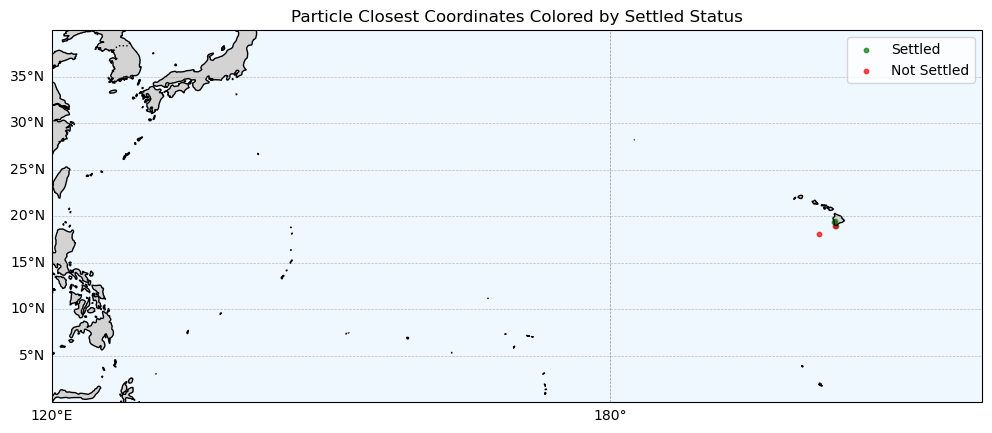

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load your dataframe
df = pd.read_csv("particle_closest_to_land.csv")

# Create figure with a Pacific-centered projection
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-160))  # center over Pacific

# Add features: land, ocean, coastlines
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='aliceblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Scatter settled vs not settled
settled = df[df['settled'] == True]
not_settled = df[df['settled'] == False]

# Plot settled points (green)
ax.scatter(
    settled['lon_closest'], settled['lat_closest'],
    color='green', s=10, label='Settled', alpha=0.7,
    transform=ccrs.PlateCarree()
)

# Plot not settled points (red)
ax.scatter(
    not_settled['lon_closest'], not_settled['lat_closest'],
    color='red', s=10, label='Not Settled', alpha=0.7,
    transform=ccrs.PlateCarree()
)

# Set map extent (Pacific region)
ax.set_extent([120, -140+360, 0, 40], crs=ccrs.PlateCarree())  # handle dateline wrap

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add legend and title
plt.legend()
plt.title("Particle Closest Coordinates Colored by Settled Status")

# Save figure
plt.savefig("particle_map.png", dpi=300, bbox_inches='tight')
plt.show()

